In [116]:
# imports and plotting utility functions
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import Lasso
import seaborn as sns
from matplotlib import pylab as plt
from statsmodels.regression.linear_model import OLS
from scipy.linalg import norm

rf_cmp = RandomForestRegressor(n_estimators=250, criterion='mse', bootstrap=True, oob_score=True, random_state=0)

def plot_lr(true_coefs, est_coefs, pvals, var_names=None, rf_cmp_coef=None):
    n_feat = len(est_coefs)
    where_sign = lr_pvalues < 0.05
    plt.figure(figsize=(15, 7))
    # print non-significant betas
    plt.scatter(np.arange(X.shape[1]), est_coefs, s=150, color='red', label='estimated betas', alpha=0.5)
    if true_coefs is not None:
        plt.scatter(np.arange(X.shape[1]), true_coefs, s=150, color='black', label='true betas', alpha=0.5)
    if rf_cmp_coef is not None:
        plt.scatter(np.arange(X.shape[1]), rf_cmp_coef, s=150, marker='D', color='steelblue', label='RandomForest importances', alpha=0.5)

    # print star significant betas and their values
    axes = plt.gca()
    #import pdb; pdb.set_trace()
    y_min, y_max = axes.get_ylim()
    axes.set_ylim(y_min * 1.25, y_max * 1.25)
    sign_y = np.sum(where_sign) * [y_min]
    plt.scatter(np.arange(X.shape[1])[where_sign], sign_y, color='red', label='significant at p<0.05', s=150, marker=(5, 1), alpha=0.75, linewidth=3)
    for i_b, p in enumerate(pvals):
        plt.text(x=i_b - 0.25, y=y_min * 1.10, s='$p$=%.3f' % p)

    plt.xlabel('input variables')
    #plt.xticks(np.arange(n_feat)[::2], (np.arange(n_feat) + 1)[::2])
    if var_names is None:
        plt.xticks(np.arange(n_feat), (np.arange(n_feat) + 1), fontsize=16)
    else:
        plt.xticks(np.arange(n_feat), var_names, fontsize=16)
    plt.grid(True)
    plt.title('Linear regression', fontsize=16)
    plt.legend(loc='upper right', fontsize=14)

def plot_regr_paths(coefs, accs, nonzeros, C_grid, var_names=None, unbiased_accs=None):
    n_cols = 2
    n_rows = 1
    n_verticals = len(coefs)
    n_feat = len(coefs)

    my_palette = np.array([
        '#F47D7D', '#FBEF69', '#98E466', '#000000',
        '#A7794F', '#CCCCCC', '#85359C', '#FF9300', '#FF0030', 'grey', 'blue', 'salmon', '#4BBCF6',
        'green', 'tomato', 'darkred', 'black', 'cyan', 'lime'
    ])
    my_colors = np.array(['???????'] * coefs.shape[-1])
    i_col = 0
    new_grp_pts_x = []
    new_grp_pts_y = []
    new_grp_pts_col = []
    new_grp_pts_total = []

    for i_vertical, (params, acc, C) in enumerate(zip(
        coefs, accs, C_grid)):
        b_notset = my_colors == '???????'
        b_nonzeros = params == 0
        b_coefs_of_new_grp = np.logical_and(b_notset, b_nonzeros)

        #if i_vertical >= 17:
        #    import pdb; pdb.set_trace()

        if np.sum(b_coefs_of_new_grp) > 0:
            i_col += 1

            # we found a new subset that became 0
            for new_i in np.where(b_coefs_of_new_grp == True)[0]:
                # color all coefficients of the current group
                cur_col = my_palette[i_col]
                my_colors[new_i] = cur_col

            new_grp_pts_x.append(C)
            new_grp_pts_y.append(acc)
            new_grp_pts_col.append(cur_col)
            new_grp_pts_total.append(np.sum(b_nonzeros))

    if var_names is None:
        X_colnames = np.arange(n_feat) + 1
    else:
        X_colnames = var_names
            
    subplot_xlabel = '#nonzero coefficients'

    f, axarr = plt.subplots(nrows=n_rows, ncols=n_cols,
        figsize=(15, 10), facecolor='white')
    t, i_col = 0, 0

    for i_line in range(X.shape[-1]):
        axarr[i_col].plot(np.log10(C_grid),
            coefs[:, i_line], label=X_colnames[i_line],
                color=my_colors[i_line], linewidth=1.5)

    # axarr[0].set_xticks(np.arange(len(C_grid)))
    # axarr[0].set_xticklabels(np.log10(C_grid))  #, rotation=75)
    axarr[i_col].set_xlabel(subplot_xlabel, fontsize=10)
    axarr[i_col].legend(loc='lower left', fontsize=14, markerscale=10)
    axarr[0].grid(True)
    # axarr[i_col].set_ylabel('Item groups', fontsize=16)
    axarr[0].set_title('LASSO: Groups of selected variables', fontsize=16)
    axarr[0].set_xticks(np.log10(C_grid))
    axarr[0].set_xticklabels(nonzeros)

    # axarr[1].axis('off')
    #import pdb; pdb.set_trace()
    if unbiased_accs is not None:
        axarr[1].plot(np.arange(len(unbiased_accs)), unbiased_accs, color='orange',
                     linewidth=4, label='prediction accuracy (debiased)')
    axarr[1].plot(np.arange(len(accs)), accs, color='black',
                     linewidth=3, label='prediction accuracy')
    # axarr[1].set_title('ACCURACY')
    axarr[1].set_ylim(-1.05, 1.05)
    axarr[1].grid(True)
    # axarr[1].set_xticklabels(np.log10(C_grid), '')
    axarr[1].set_xticks(np.arange(n_verticals))
    axarr[1].set_xticklabels(nonzeros)
    axarr[1].set_xlabel(subplot_xlabel, fontsize=10)
    # axarr[1].set_ylabel('Out-of-sample accuracy', fontsize=16)
    axarr[1].legend(loc='upper right', fontsize=14, markerscale=10)
    axarr[1].set_title('LASSO: Out-of-sample accuracy ($R^2$ score)', fontsize=16)

    
def corrfunc(x, y, **kws):
    from scipy import stats
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)


In [117]:
import statsmodels.api as sm

# https://datascience.stackexchange.com/questions/937/does-scikit-learn-have-forward-selection-stepwise-regression-algorithm
def fwd_stepwise_selection(X, y, initial_list=[], verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while len(included) < X.shape[1]:
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        best_feature = new_pval.argmin()
        included.append(best_feature)
        if verbose:
            print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
    return included

In [118]:
# statistical helper functions
def compute_Lasso_regpath(X, y, C_grid):
    coef_list2 = []
    acc_list2 = []
    acc_unbiased_list2 = []
    nonzero_list2 = []
    for i_step, my_C in enumerate(C_grid):
        sample_accs = []
        sample_accs_unbiased = []
        sample_coef = []
        for i_subsample in range(100):
            folder = ShuffleSplit(n=len(y), n_iter=100, test_size=0.1,
                                            random_state=i_subsample)
            train_inds, test_inds = iter(folder).next()

            clf = Lasso(alpha=my_C, random_state=i_subsample)

            clf.fit(X[train_inds, :], y[train_inds])
            acc = r2_score(
                    y_true=y[test_inds],
                    y_pred=clf.predict(X[test_inds]))
            
            # get out-of-sample accuracy from unbiased linear model with selected inputs
            b_vars_to_keep = clf.coef_ != 0
            if np.sum(b_vars_to_keep) > 0:
                unbiased_lr = LinearRegression()
                unbiased_lr.fit(
                  X[train_inds, :][:, b_vars_to_keep], y[train_inds])
                unbiased_acc = r2_score(
                    y_true=y[test_inds],
                    y_pred=unbiased_lr.predict(X[test_inds][:, b_vars_to_keep]))
            else:
                unbiased_acc = 0

            sample_accs.append(acc)
            sample_accs_unbiased.append(unbiased_acc)
            sample_coef.append(clf.coef_)                

        mean_coefs = np.mean(np.array(sample_coef), axis=0)
        coef_list2.append(mean_coefs)
        acc_list2.append(np.mean(sample_accs))
        acc_unbiased_list2.append(np.mean(sample_accs_unbiased))
        notzero = np.count_nonzero(mean_coefs)
        print "alpha: %.4f acc: %.2f active_coefs: %i" % (my_C, acc, notzero)
        nonzero_list2.append(notzero)
    return np.array(coef_list2), np.array(acc_list2), np.array(nonzero_list2), np.array(acc_unbiased_list2)

# Diabetes: 2 very predictive, but only 1 significant variable

Dataset summary: Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

Data Set Characteristics:

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attributes:
    :Age:
    :Sex:
    :Body mass index:
    :Average blood pressure:
    :S1:
    :S2:
    :S3:
    :S4:
    :S5:
    :S6:

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) "Least Angle Regression," Annals of Statistics (with discussion), 407-499.
(http://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf)

In [133]:
import sklearn.datasets as ds  
bun = ds.load_diabetes()
X, y = bun.data, bun.target
X = StandardScaler().fit_transform(X)
feat_names = bun.feature_names




In [ ]:
g = sns.pairplot(pd.DataFrame(X, columns=feat_names), kind="reg", diag_kind="kde")
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

Signal-to-noise ratio: 0.0004
alpha: 0.0100 acc: 0.51 active_coefs: 10
alpha: 0.0147 acc: 0.51 active_coefs: 10
alpha: 0.0215 acc: 0.51 active_coefs: 10
alpha: 0.0316 acc: 0.51 active_coefs: 10
alpha: 0.0464 acc: 0.51 active_coefs: 10
alpha: 0.0681 acc: 0.51 active_coefs: 10
alpha: 0.1000 acc: 0.51 active_coefs: 10
alpha: 0.1468 acc: 0.50 active_coefs: 10
alpha: 0.2154 acc: 0.50 active_coefs: 10
alpha: 0.3162 acc: 0.50 active_coefs: 10
alpha: 0.4642 acc: 0.50 active_coefs: 9
alpha: 0.6813 acc: 0.50 active_coefs: 9
alpha: 1.0000 acc: 0.50 active_coefs: 9
alpha: 1.4678 acc: 0.50 active_coefs: 10
alpha: 2.1544 acc: 0.49 active_coefs: 8
alpha: 3.1623 acc: 0.49 active_coefs: 8
alpha: 4.6416 acc: 0.49 active_coefs: 7
alpha: 6.8129 acc: 0.48 active_coefs: 6
alpha: 10.0000 acc: 0.46 active_coefs: 5
alpha: 14.6780 acc: 0.41 active_coefs: 4
alpha: 21.5443 acc: 0.34 active_coefs: 3
alpha: 31.6228 acc: 0.19 active_coefs: 2
alpha: 46.4159 acc: -0.01 active_coefs: 1
alpha: 68.1292 acc: -0.01 active_

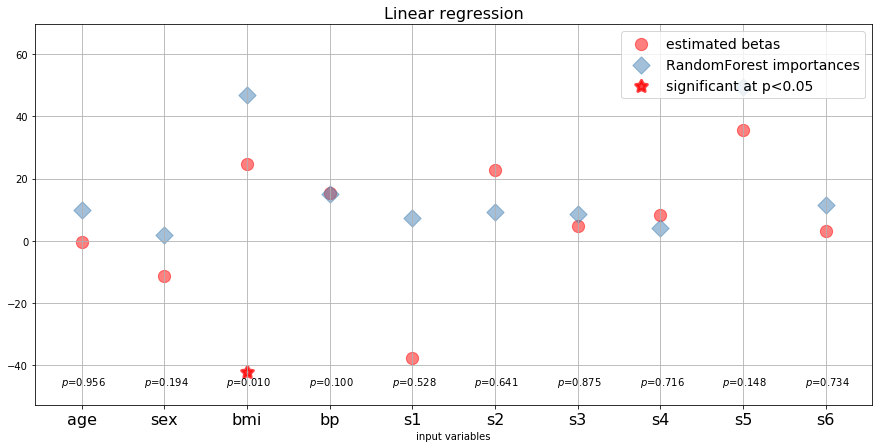

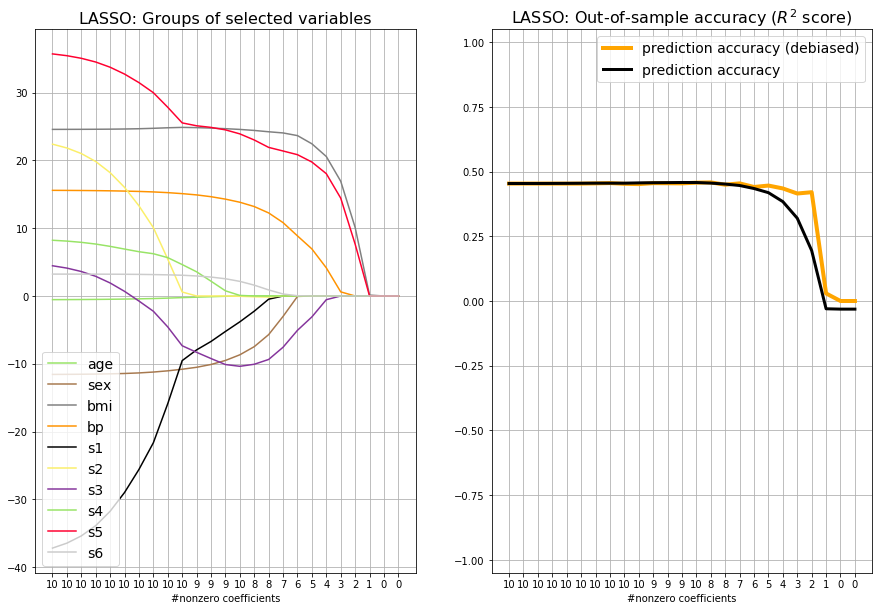

In [137]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

snr = (norm(a=lr_coefs, ord=2) ** 2) / (norm(a=res.resid, ord=2) ** 2)
print('Signal-to-noise ratio: %.4f' % snr)

rf_cmp.fit(X, y)
rf_cmp.feature_importances_

# compute Lasso regularization paths
C_grid = np.logspace(-2, 2, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names, rf_cmp_coef=rf_cmp.feature_importances_ * 10 * np.mean(np.abs(lr_coefs)))
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list)

In [136]:
model.fit?

In [60]:
sel_w_pvals = fwd_stepwise_selection(pd.DataFrame(X, columns=feat_names), y, verbose=True)
print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))

Add  bmi                            with p-value 3.46601e-42
Add  s5                             with p-value 3.03968e-20
Add  bp                             with p-value 3.74192e-05
Add  s1                             with p-value 0.00145437
Add  sex                            with p-value 0.00922919
Add  s2                             with p-value 0.000272264
Add  s4                             with p-value 0.261918
Add  s6                             with p-value 0.304022
Add  s3                             with p-value 0.638562
Add  age                            with p-value 0.867
Forward-stepwise selection: bmi -> s5 -> bp -> s1 -> sex -> s2 -> s4 -> s6 -> s3 -> age


### inference: only var 3 significant, prediction: this one is selected too but as predictive as var 9 and similar to 4 and 7 -> S5 is as predictive as bmi but not significant, same goes for bp and s3
### bp has a lower p-value than s5, but s5 is nevertheless more predictive than bp (partly explained by their correlation of 0.39)
### bmi is significant, but alone R2 is less 0.05 !!!!!!!!!!!!!

In [5]:
print(res.summary(xname=feat_names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     5.100
Date:                Sun, 11 Mar 2018   Prob (F-statistic):           4.72e-07
Time:                        16:41:25   Log-Likelihood:                -2873.9
No. Observations:                 442   AIC:                             5768.
Df Residuals:                     432   BIC:                             5809.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.4762      8.560     -0.056      0.9

# Prostata dataset: not significant, but predictive

Prostate Cancer Data
Description
These data come from a study that examined the correlation between the level of prostate specific antigen and a number of clinical measures in men who were about to receive a radical prostatectomy. It is data frame with 97 rows and 9 columns.

Usage
data(Prostate)
Format
The data frame has the following components:

lcavol
log(cancer volume)
lweight
log(prostate weight)
age
age
lbph
log(benign prostatic hyperplasia amount)
svi
seminal vesicle invasion
lcp
log(capsular penetration)
gleason
Gleason score
pgg45
percentage Gleason scores 4 or 5
lpsa
log(prostate specific antigen)
Source
Stamey, T.A., Kabalin, J.N., McNeal, J.E., Johnstone, I.M., Freiha, F., Redwine, E.A. and Yang, N. (1989)
Prostate specific antigen in the diagnosis and treatment of adenocarcinoma of the prostate: II. radical prostatectomy treated patients, Journal of Urology 141(5), 1076–1083.

Lasso paths from Hastie et al. 2001

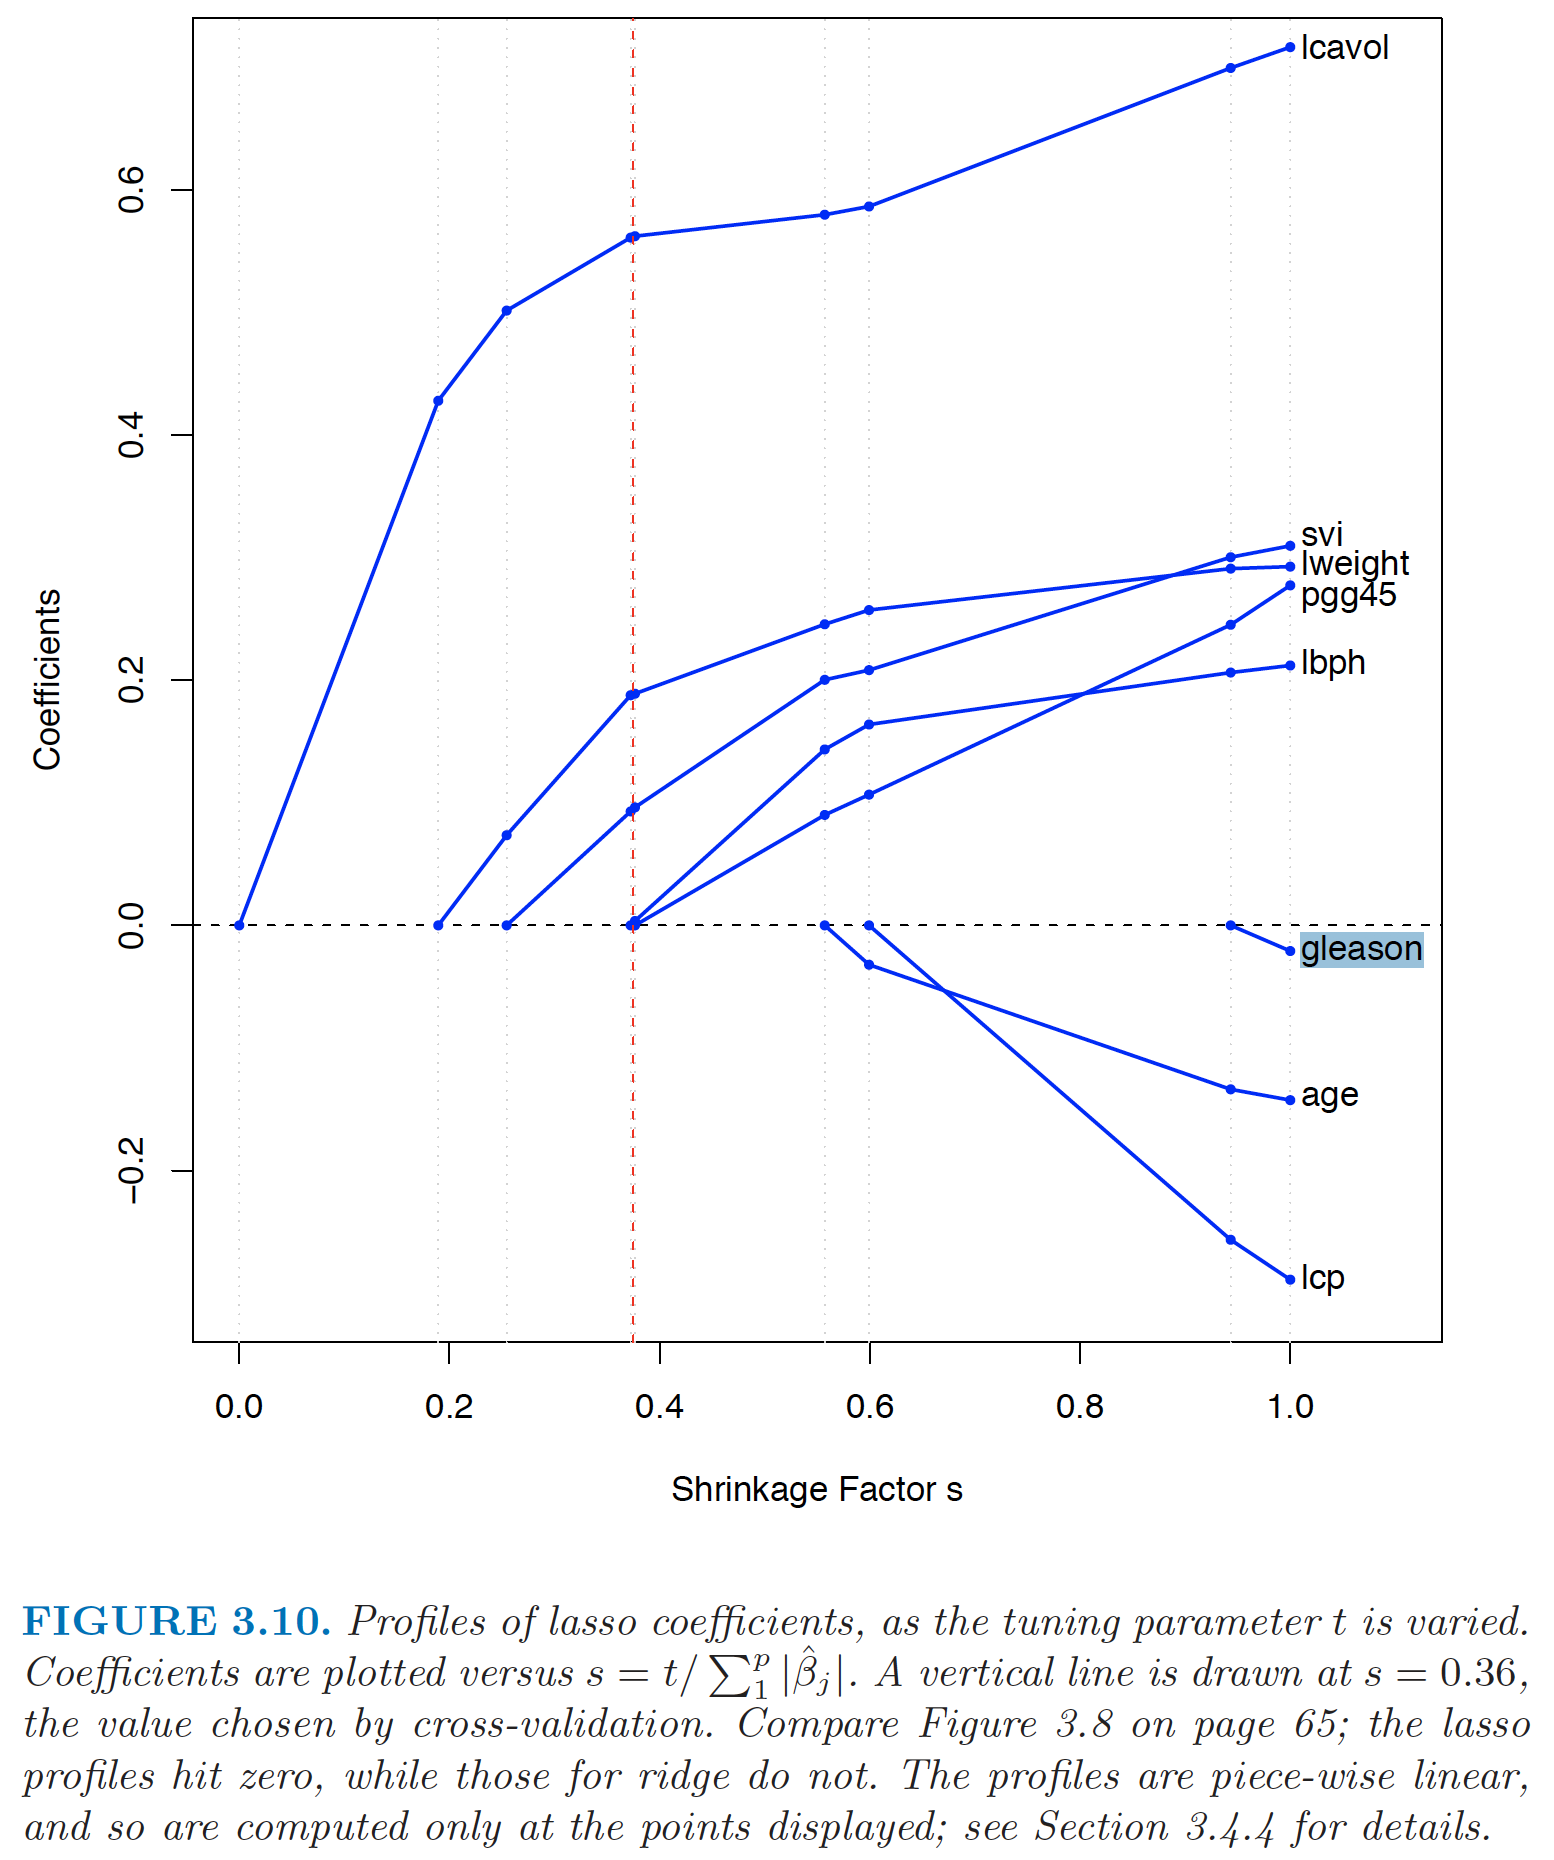

In [121]:
import pandas as pd
df_prostate = pd.read_csv('dataset_prostate.csv')
y = df_prostate['lpsa']
feat_names = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
X = StandardScaler().fit_transform(df_prostate[feat_names])


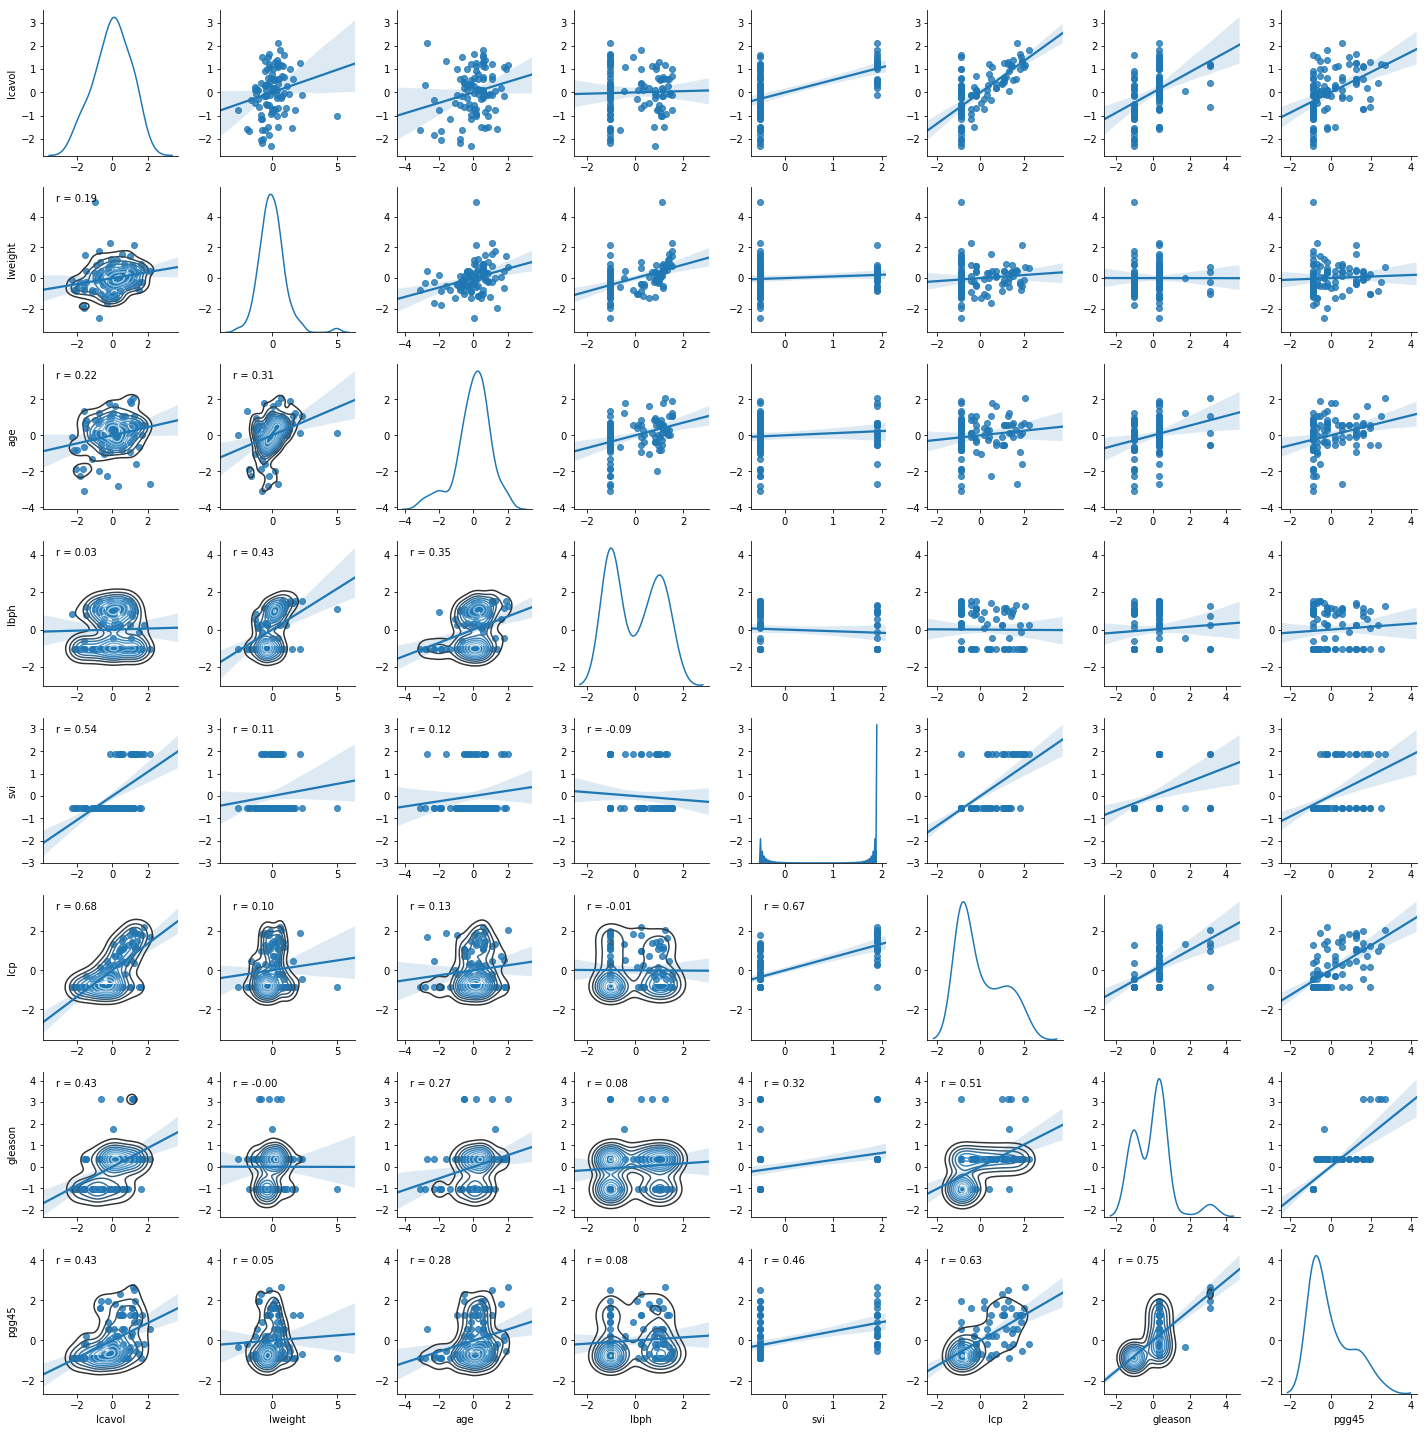

In [62]:
g = sns.pairplot(pd.DataFrame(X, columns=feat_names), kind="reg", diag_kind="kde")
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

Signal-to-noise ratio: 0.0004


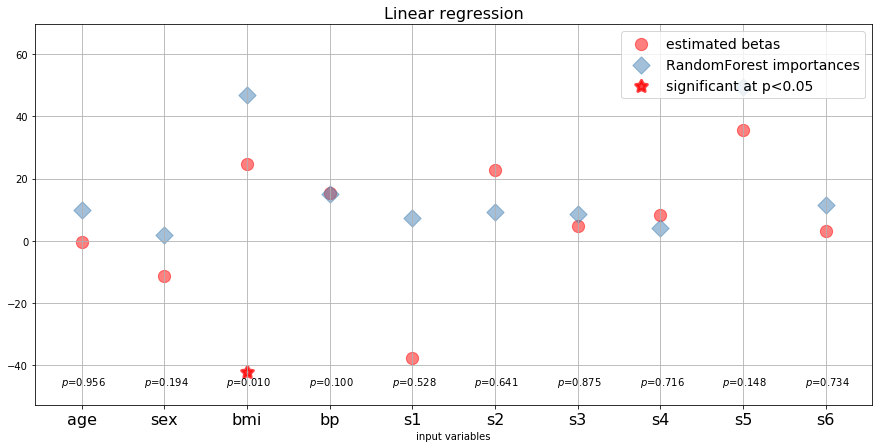

In [139]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

snr = (norm(a=lr_coefs, ord=2) ** 2) / (norm(a=res.resid, ord=2) ** 2)
print('Signal-to-noise ratio: %.4f' % snr)

rf_cmp.fit(X, y)
rf_cmp.feature_importances_

# compute Lasso regularization paths
C_grid = np.logspace(-4, 0.25, 25)
#coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names, rf_cmp_coef=rf_cmp.feature_importances_ * 10 * np.mean(np.abs(lr_coefs)))
#plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list)


In [63]:
sel_w_pvals = fwd_stepwise_selection(pd.DataFrame(X, columns=feat_names), y, verbose=True)
print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))

Add  lcavol                         with p-value 1.11861e-17
Add  lweight                        with p-value 0.00160649
Add  svi                            with p-value 0.00202903
Add  lbph                           with p-value 0.11213
Add  age                            with p-value 0.169527
Add  pgg45                          with p-value 0.253309
Add  lcp                            with p-value 0.251271
Add  gleason                        with p-value 0.77506
Forward-stepwise selection: lcavol -> lweight -> svi -> lbph -> age -> pgg45 -> lcp -> gleason


### no significants (trending significant at 0.08 is also single most predictive variable); ~5 items not full set of 9 variables were clearly very predictive -> the widely practiced Gleason score (?) comes up as disturbing prediction
### second-most important variable diverged in fwd-stepwise selection and Lasso selection -> tiny difference

In [69]:
print(res.summary(xname=feat_names))

                            OLS Regression Results                            
Dep. Variable:                   lpsa   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     1.456
Date:                Thu, 08 Mar 2018   Prob (F-statistic):              0.185
Time:                        18:25:46   Log-Likelihood:                -229.14
No. Observations:                  97   AIC:                             474.3
Df Residuals:                      89   BIC:                             494.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
lcavol         0.6883      0.390      1.764      0.0

# Heart dataset (ISL): ???

Dataset summary: These data contain a binary outcome HD for 303 patients who presented with chest pain (binary outcome). 

In [64]:
import pandas as pd
df_heart = pd.read_csv('dataset_heart_ISL.csv').fillna(value=0)
feat_names = ['Age', u'Sex', u'RestBP', u'Chol', u'Fbs',
       u'RestECG', u'MaxHR', u'ExAng', u'Oldpeak', u'Slope', u'Ca', u'Thal', u'ChestPain']
y = np.asarray(df_heart['AHD'] == 'Yes', dtype=np.float)

df_part1 = pd.DataFrame(StandardScaler().fit_transform(df_heart[feat_names[:-2]].values), columns=feat_names[:-2])
df_part2 = pd.get_dummies(df_heart[feat_names[-2:]])
#pd.concat([df_part1, df_part2], axis=1)
X = np.hstack((df_part1.values, df_part2.values))
feat_names = list(df_part1.columns) + list(df_part2.columns)



In [65]:
g = sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']),
             kind="reg", diag_kind="kde", hue='out')
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

/Users/admin/anaconda2/lib/python2.7/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


alpha: 0.0001 acc: 0.36 active_coefs: 19
alpha: 0.0002 acc: 0.36 active_coefs: 19
alpha: 0.0002 acc: 0.36 active_coefs: 19
alpha: 0.0003 acc: 0.36 active_coefs: 19
alpha: 0.0005 acc: 0.36 active_coefs: 19
alpha: 0.0008 acc: 0.36 active_coefs: 19
alpha: 0.0012 acc: 0.36 active_coefs: 19
alpha: 0.0017 acc: 0.36 active_coefs: 18
alpha: 0.0026 acc: 0.36 active_coefs: 17
alpha: 0.0039 acc: 0.36 active_coefs: 17
alpha: 0.0059 acc: 0.37 active_coefs: 17
alpha: 0.0089 acc: 0.37 active_coefs: 16
alpha: 0.0133 acc: 0.37 active_coefs: 14
alpha: 0.0200 acc: 0.37 active_coefs: 14
alpha: 0.0301 acc: 0.37 active_coefs: 12
alpha: 0.0453 acc: 0.36 active_coefs: 11
alpha: 0.0681 acc: 0.33 active_coefs: 9
alpha: 0.1024 acc: 0.27 active_coefs: 6
alpha: 0.1540 acc: 0.19 active_coefs: 4
alpha: 0.2315 acc: -0.00 active_coefs: 3
alpha: 0.3481 acc: -0.00 active_coefs: 0
alpha: 0.5233 acc: -0.00 active_coefs: 0
alpha: 0.7867 acc: -0.00 active_coefs: 0
alpha: 1.1828 acc: -0.00 active_coefs: 0
alpha: 1.7783 acc: 

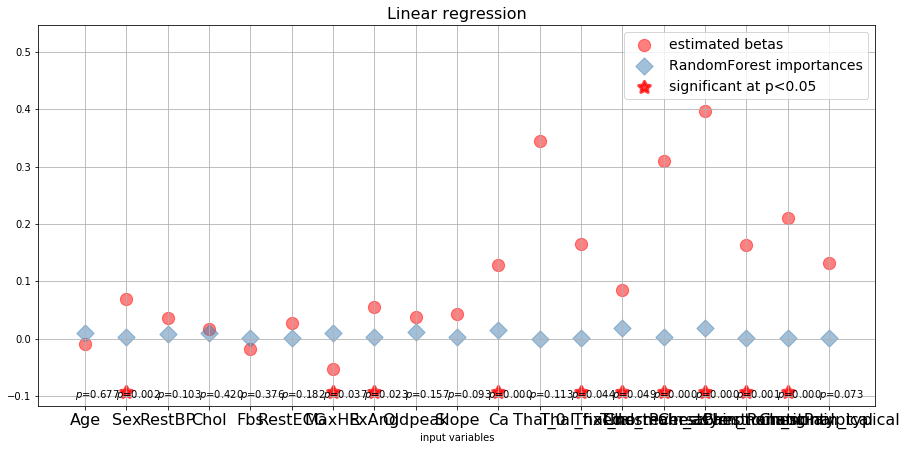

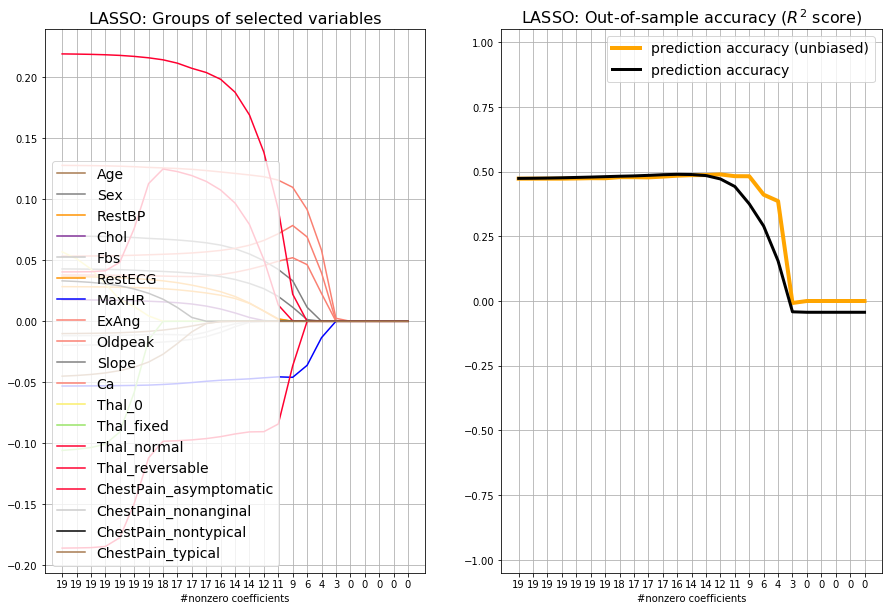

In [66]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

rf_cmp.fit(X, y)
rf_cmp.feature_importances_


# compute Lasso regularization paths
C_grid = np.logspace(-4, 0.25, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names, rf_cmp_coef=rf_cmp.feature_importances_ * np.mean(np.abs(lr_coefs)))
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list)

In [67]:
sel_w_pvals = fwd_stepwise_selection(pd.DataFrame(X, columns=feat_names), y, verbose=True)
print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))

Add  Thal_normal                    with p-value 1.74239e-22
Add  ChestPain_asymptomatic         with p-value 2.14709e-14
Add  Ca                             with p-value 3.1774e-10
Add  ExAng                          with p-value 0.000330868
Add  Oldpeak                        with p-value 0.00168192
Add  Sex                            with p-value 0.013402
Add  MaxHR                          with p-value 0.0250925
Add  RestECG                        with p-value 0.094838
Add  Thal_fixed                     with p-value 0.129189
Add  Slope                          with p-value 0.121301
Add  RestBP                         with p-value 0.146268
Add  ChestPain_nontypical           with p-value 0.313483
Add  Fbs                            with p-value 0.366404
Add  Chol                           with p-value 0.4467
Add  Age                            with p-value 0.658948
Add  ChestPain_nonanginal           with p-value 0.700473
Add  ChestPain_typical              with p-value 0.828331
Ad

In [38]:
print(res.summary(xname=feat_names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     20.58
Date:                Fri, 09 Mar 2018   Prob (F-statistic):           4.04e-40
Time:                        17:39:17   Log-Likelihood:                -97.524
No. Observations:                 303   AIC:                             231.0
Df Residuals:                     285   BIC:                             297.9
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Age                       -0

# South African Heart dataset: more significant than predictable

Dataset summary (ESL): A retrospective sample of males in a heart-disease high-risk region of the Western Cape, South Africa. There are roughly two controls per case of coronary heart disease. Many of the coronary heart disease positive men have undergone blood pressure reduction treatment and other programs to reduce their risk
factors after their coronary heart disease event. In some cases the measurements were made after these treatments. These data are taken from a larger dataset, described in Rousseauw et al, 1983, South African Medical Journal.

Based on this data, does having a family history of coronary heart disease affect a patients chance of having coronary heart disease? Does this result change for patients younger than 40 years old? What about for patients aged 40 years or older?

sbp		systolic blood pressure
tobacco		cumulative tobacco (kg)
ldl		low densiity lipoprotein cholesterol
adiposity
famhist		family history of heart disease (Present, Absent)
typea		type-A behavior
obesity
alcohol		current alcohol consumption
age		age at onset
chd		response, coronary heart disease

In [123]:
import pandas as pd
df_africa = pd.read_excel('dataset_south_african_heart_disease.xls')

df_africa

,row,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1
5,6,132,6.20,6.47,36.21,Present,62,30.77,14.14,45,0
6,7,142,4.05,3.38,16.20,Absent,59,20.81,2.62,38,0
7,8,114,4.08,4.59,14.60,Present,62,23.11,6.72,58,1
8,9,114,0.00,3.83,19.40,Present,49,24.86,2.49,29,0
9,10,132,0.00,5.80,30.96,Present,69,30.11,0.00,53,1


In [124]:
feat_names = ['sbp', u'tobacco', u'ldl', u'adiposity', u'famhist', u'typea',
       u'obesity', u'alcohol', u'age']
df_africa['famhist'] = df_africa['famhist'] == 'Present'
X = StandardScaler().fit_transform(df_africa[feat_names].values)
y = df_africa['chd'].values

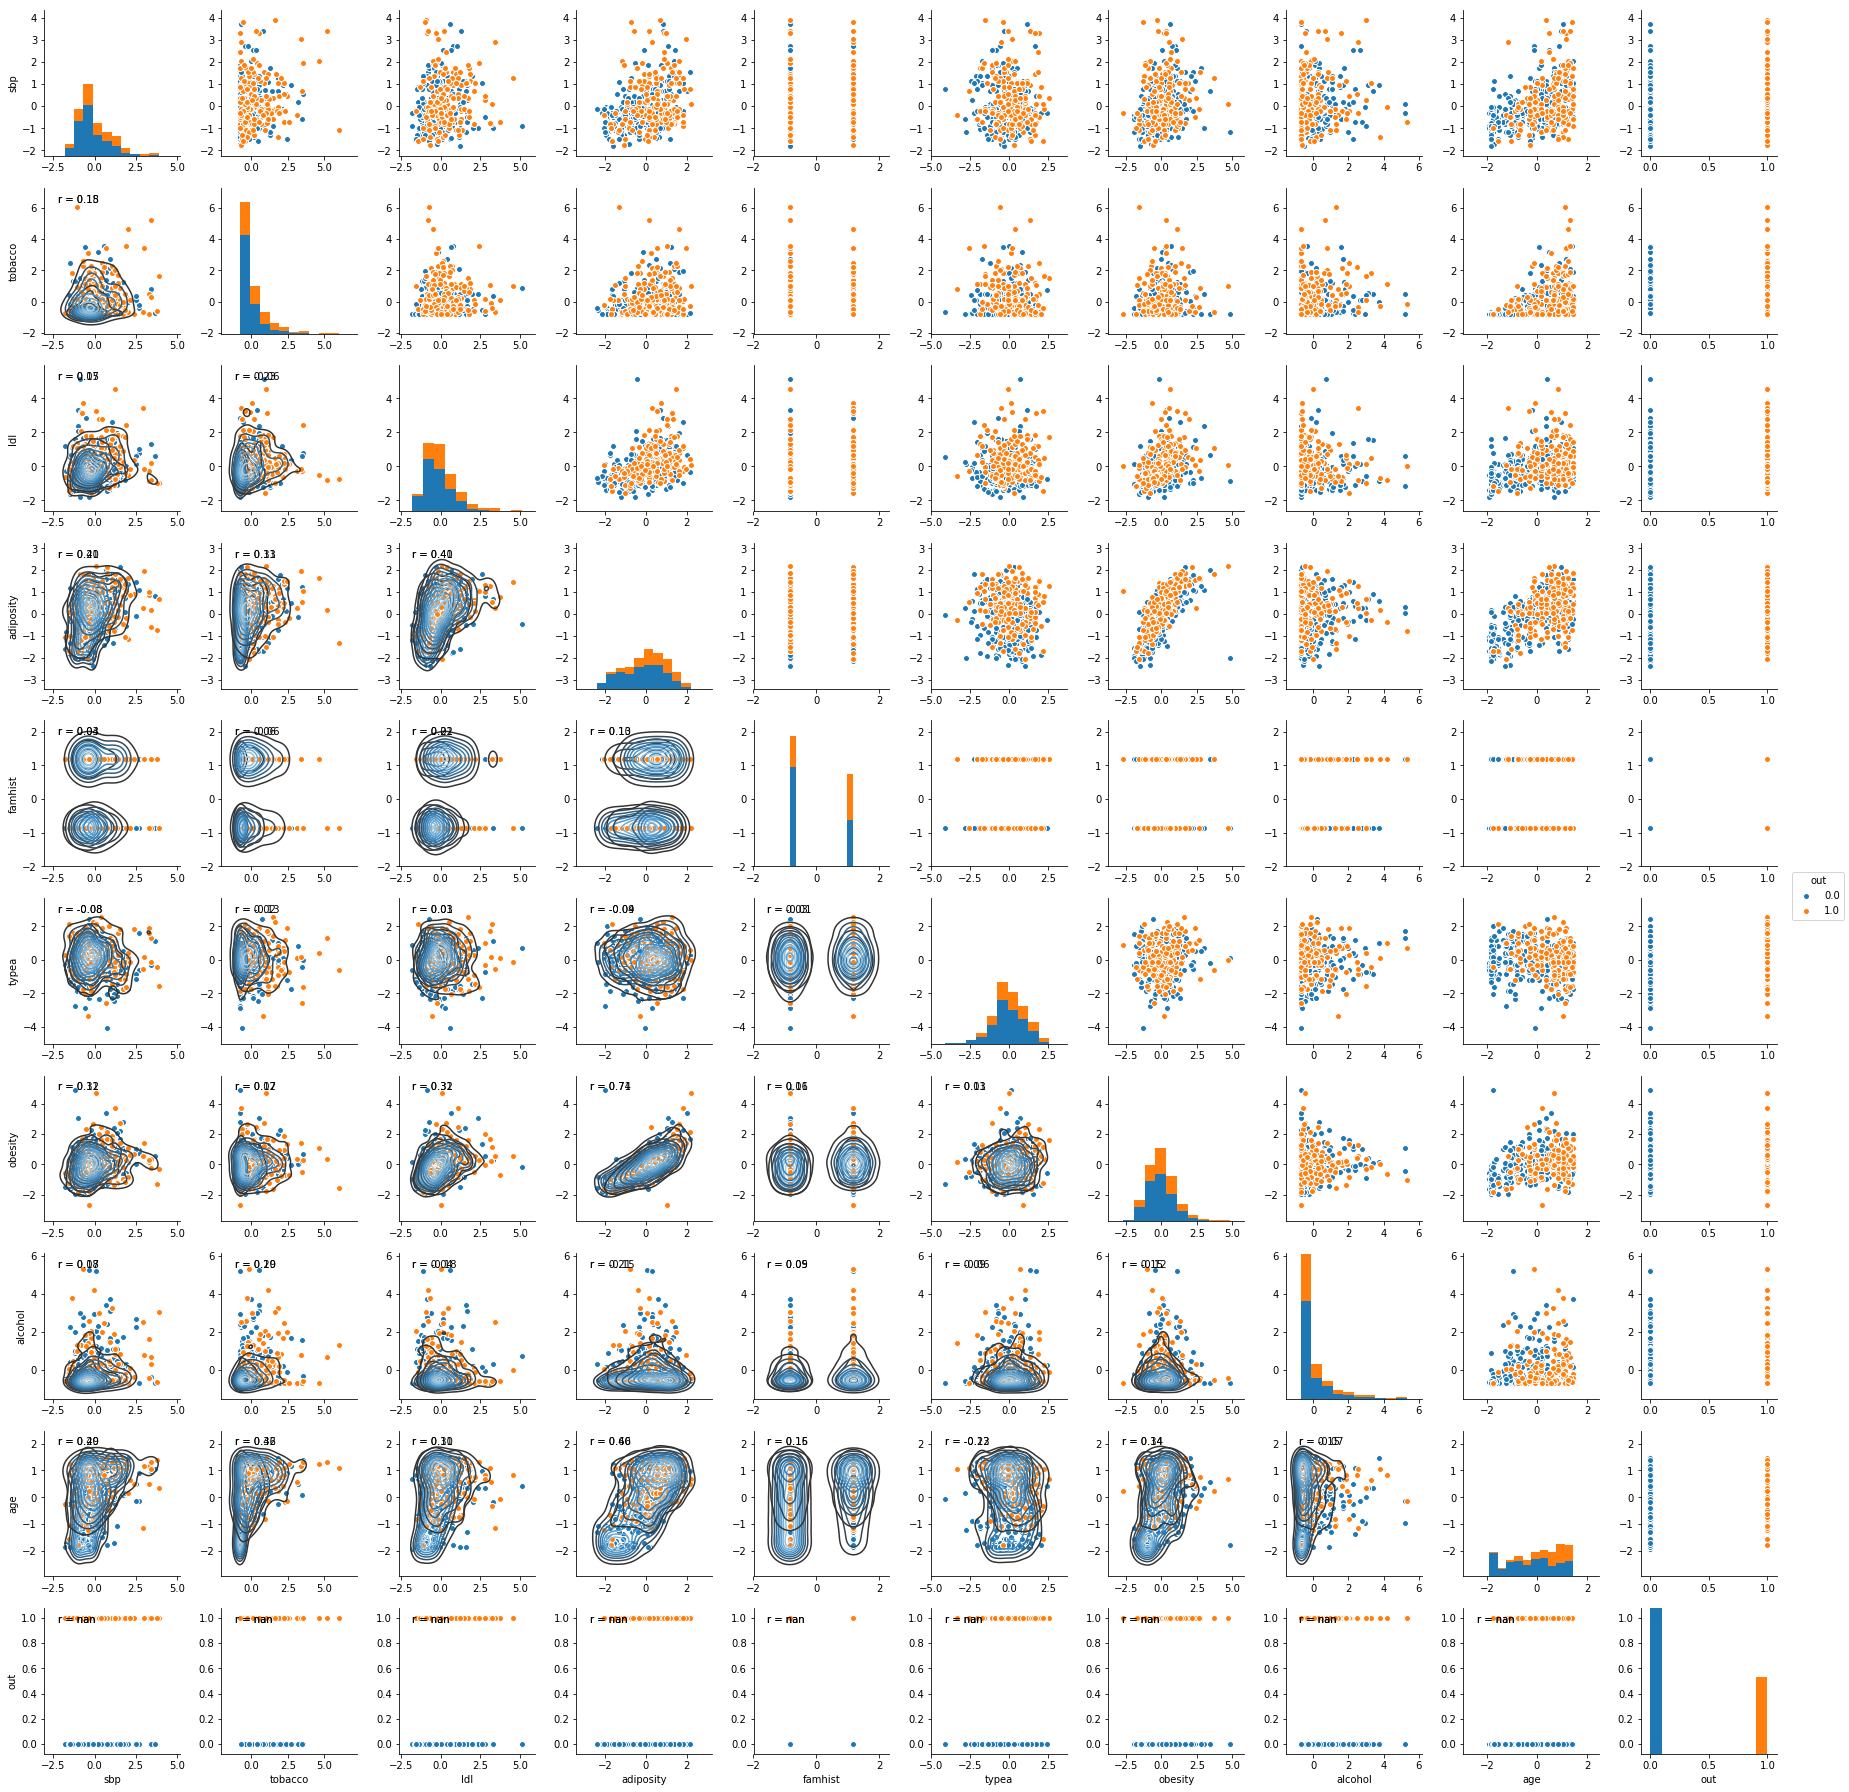

In [42]:
g = sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']),
              hue='out')
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

Signal-to-noise ratio: 0.0004
alpha: 0.0001 acc: 0.51 active_coefs: 10
alpha: 0.0002 acc: 0.51 active_coefs: 10
alpha: 0.0002 acc: 0.51 active_coefs: 10
alpha: 0.0003 acc: 0.51 active_coefs: 10
alpha: 0.0005 acc: 0.51 active_coefs: 10
alpha: 0.0008 acc: 0.51 active_coefs: 10
alpha: 0.0012 acc: 0.51 active_coefs: 10
alpha: 0.0017 acc: 0.51 active_coefs: 10
alpha: 0.0026 acc: 0.51 active_coefs: 10
alpha: 0.0039 acc: 0.51 active_coefs: 10
alpha: 0.0059 acc: 0.51 active_coefs: 10
alpha: 0.0089 acc: 0.51 active_coefs: 10
alpha: 0.0133 acc: 0.51 active_coefs: 10
alpha: 0.0200 acc: 0.51 active_coefs: 10
alpha: 0.0301 acc: 0.51 active_coefs: 10
alpha: 0.0453 acc: 0.51 active_coefs: 10
alpha: 0.0681 acc: 0.51 active_coefs: 10
alpha: 0.1024 acc: 0.51 active_coefs: 10
alpha: 0.1540 acc: 0.50 active_coefs: 10
alpha: 0.2315 acc: 0.50 active_coefs: 10
alpha: 0.3481 acc: 0.50 active_coefs: 10
alpha: 0.5233 acc: 0.50 active_coefs: 9
alpha: 0.7867 acc: 0.50 active_coefs: 9
alpha: 1.1828 acc: 0.50 activ

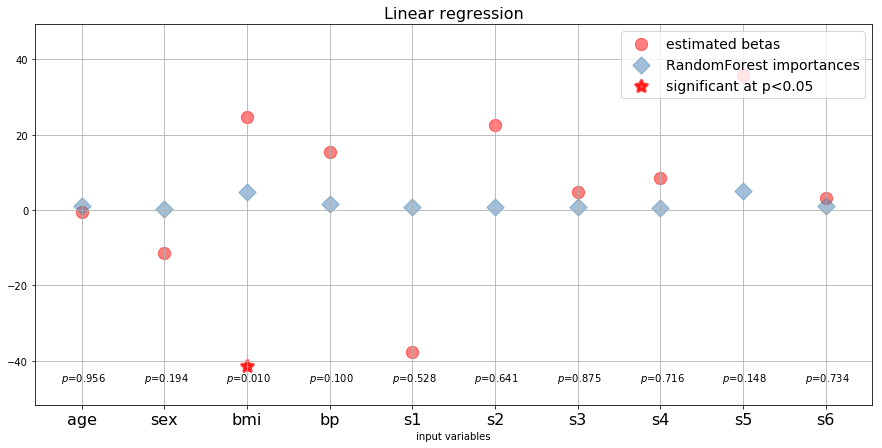

ValueError: Invalid RGBA argument: '???????'

In [140]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

snr = (norm(a=lr_coefs, ord=2) ** 2) / (norm(a=res.resid, ord=2)  ** 2)
print('Signal-to-noise ratio: %.4f' % snr)

rf_cmp.fit(X, y)
rf_cmp.feature_importances_

# compute Lasso regularization paths
C_grid = np.logspace(-4, 0.25, 25)
coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names, rf_cmp_coef=rf_cmp.feature_importances_ * np.mean(np.abs(lr_coefs)))
plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list)


In [71]:
sel_w_pvals = fwd_stepwise_selection(pd.DataFrame(X, columns=feat_names), y, verbose=True)
print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))

Add  age                            with p-value 1.07418e-16
Add  famhist                        with p-value 1.10497e-05
Add  tobacco                        with p-value 0.000318949
Add  ldl                            with p-value 0.00133352
Add  typea                          with p-value 0.00585821
Add  obesity                        with p-value 0.115856
Add  sbp                            with p-value 0.199105
Add  adiposity                      with p-value 0.640422
Add  alcohol                        with p-value 0.775502
Forward-stepwise selection: age -> famhist -> tobacco -> ldl -> typea -> obesity -> sbp -> adiposity -> alcohol


### conclusion: largely in agreement
### the 5 significant variables are also the 5 most predictive variables -> sbp and obesity are 6. and 7. most predictive variables but they are not among the significant ones (p > 0.2 and p > 0.3)

In [28]:
print(res.summary(xname=feat_names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     9.182
Date:                Fri, 09 Mar 2018   Prob (F-statistic):           8.04e-13
Time:                        15:54:49   Log-Likelihood:                -371.89
No. Observations:                 462   AIC:                             761.8
Df Residuals:                     453   BIC:                             799.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
sbp            0.0274      0.028      0.973      0.3

# FEV: significant but largely ignorable for prediction

In [ ]:
Dataset summary: 

In [126]:
import pandas as pd
df_fev = pd.read_csv('dataset_FEV.csv')

df_fev.drop(labels='id', axis=1, inplace=True)

In [102]:
df_fev

,age,fev,height,sex,smoke
0,9,1.708,57.0,female,non-current smoker
1,8,1.724,67.5,female,non-current smoker
2,7,1.720,54.5,female,non-current smoker
3,9,1.558,53.0,male,non-current smoker
4,9,1.895,57.0,male,non-current smoker
5,8,2.336,61.0,female,non-current smoker
6,6,1.919,58.0,female,non-current smoker
7,6,1.415,56.0,female,non-current smoker
8,8,1.987,58.5,female,non-current smoker
9,9,1.942,60.0,female,non-current smoker


In [127]:
feat_names = ['age', u'fev', u'height', u'sex', u'smoke']
df_part1 = pd.DataFrame(StandardScaler().fit_transform(df_fev[feat_names[:-2]].values), columns=feat_names[:-2])
df_part2 = pd.get_dummies(df_fev[feat_names[-2:]], drop_first=True)
#pd.concat([df_part1, df_part2], axis=1)
y = StandardScaler().fit_transform(df_part1['fev'].values[:, None])[:, 0]
df_part1.drop(labels='fev', axis=1, inplace=True)
X = np.hstack((df_part1.values, df_part2.values))
feat_names = list(df_part1.columns) + list(df_part2.columns)


/Users/admin/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'color', 'label'
  s)
/Users/admin/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/Users/admin/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/Users/admin/anaconda2/lib/python2.7/site-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/Users/admin/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:1533: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/admin/anaconda2/l

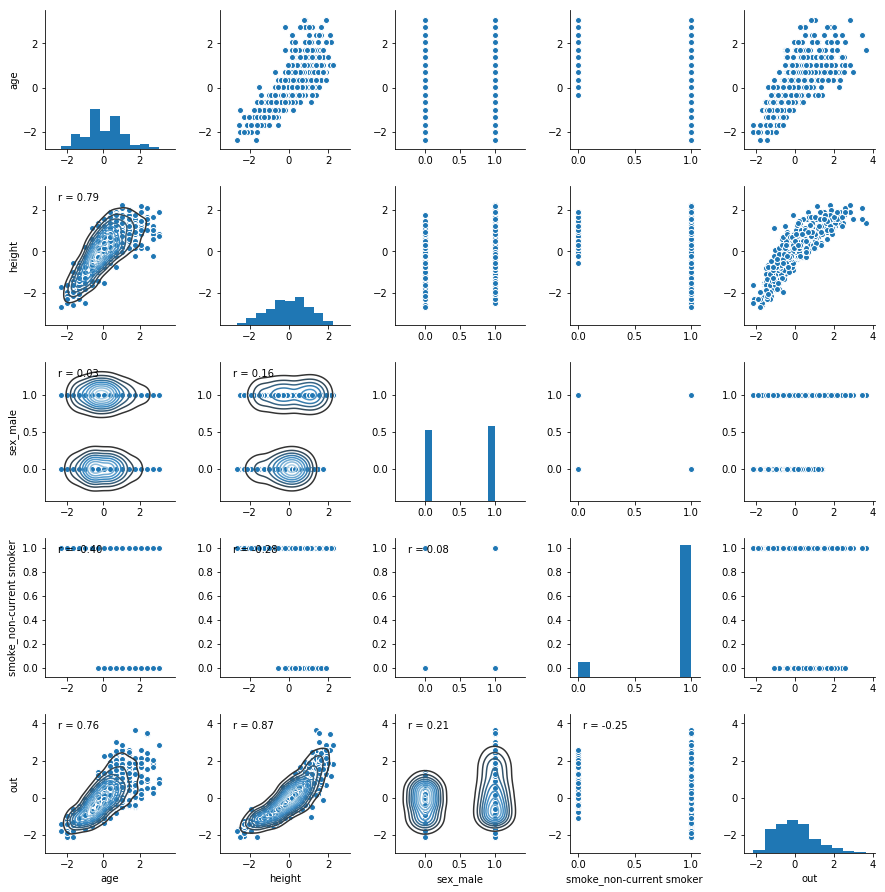

In [16]:
g = sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']))
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

Signal-to-noise ratio: 9.9583


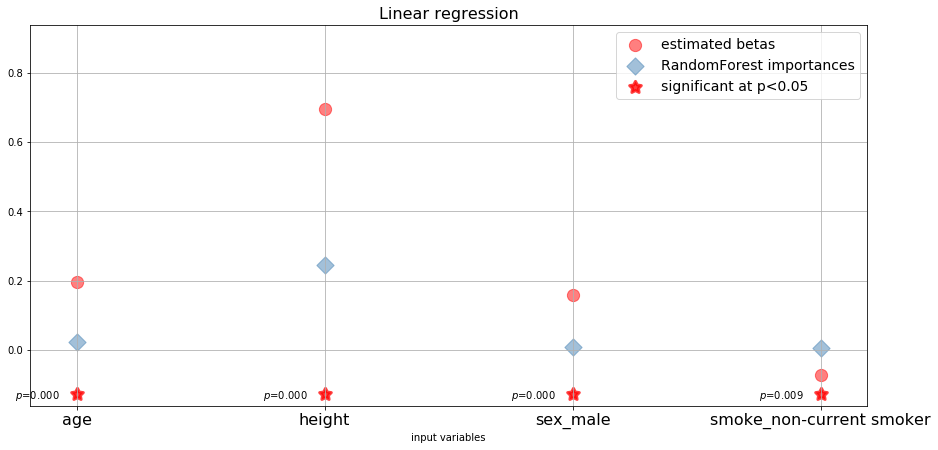

In [128]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

snr = (norm(a=lr_coefs, ord=2) ** 2) / (norm(a=res.resid, ord=2) ** 2)
print('Signal-to-noise ratio: %.4f' % snr)

rf_cmp.fit(X, y)
rf_cmp.feature_importances_

# compute Lasso regularization paths
C_grid = np.logspace(-4, 0.25, 25)
#coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names, rf_cmp_coef=rf_cmp.feature_importances_ * np.mean(np.abs(lr_coefs)))
#plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list)

In [76]:
sel_w_pvals = fwd_stepwise_selection(pd.DataFrame(X, columns=feat_names), y, verbose=True)
print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))

Add  height                         with p-value 1.57456e-200
Add  age                            with p-value 4.11176e-09
Add  sex_male                       with p-value 1.4463e-06
Add  smoke_non-current smoker       with p-value 0.141391
Forward-stepwise selection: height -> age -> sex_male -> smoke_non-current smoker


### conclusion: 4/4 input variables are highly significant, but height alone (ignoring other 3 variables) has virtually identical accuracy in predicting FEV
### the prediction regime may miss the significant mechanistic relevance of smoking
### high significance of all input variables is partly due to comparably high sample sizes facilitating low p values

In [10]:
print(res.summary(xname=feat_names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     552.3
Date:                Sun, 11 Mar 2018   Prob (F-statistic):          2.10e-207
Time:                        17:21:38   Log-Likelihood:                -443.60
No. Observations:                 654   AIC:                             895.2
Df Residuals:                     650   BIC:                             913.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
age                     

# Primary biliary cirrhosis

In [15]:
import pandas as pd
df_cir = pd.read_excel('sources_medical_datasets/_Mayo_Clinic_primary_biliary_cirrhosis_pbc.xls')

#df_fev.drop(labels='id', axis=1, inplace=True)

*** No CODEPAGE record, no encoding_override: will use 'ascii'


In [16]:
df_cir

,bili,albumin,stage,protime,sex,fu.days,age,spiders,hepatom,ascites,alk.phos,sgot,chol,trig,platelet,drug,status,edema,copper
0,14.500000,2.60,4.0,12.2,female,400,58.765228,present,present,present,1718.000000,137.949997,261.0,172.0,190.0,placebo,1,edema despite diuretic therapy,156.0
1,1.100000,4.14,3.0,10.6,female,4500,56.446270,present,present,absent,7394.799805,113.519997,302.0,88.0,221.0,placebo,0,no edema,54.0
2,1.400000,3.48,4.0,12.0,male,1012,70.072556,absent,absent,absent,516.000000,96.099998,176.0,55.0,151.0,placebo,1,"edema, no diuretic therapy",210.0
3,1.800000,2.54,4.0,10.3,female,1925,54.740589,present,present,absent,6121.799805,60.630001,244.0,92.0,183.0,placebo,1,"edema, no diuretic therapy",64.0
4,3.400000,3.53,3.0,10.9,female,1504,38.105408,present,present,absent,671.000000,113.150002,279.0,72.0,136.0,D-penicillamine,0,no edema,143.0
5,0.800000,3.98,3.0,11.0,female,2503,66.258728,absent,present,absent,944.000000,93.000000,248.0,63.0,NaN,D-penicillamine,1,no edema,50.0
6,1.000000,4.09,3.0,9.7,female,1832,55.534565,absent,present,absent,824.000000,60.450001,322.0,213.0,204.0,D-penicillamine,0,no edema,52.0
7,0.300000,4.00,3.0,11.0,female,2466,53.056812,absent,absent,absent,4651.200195,28.379999,280.0,189.0,373.0,D-penicillamine,1,no edema,52.0
8,3.200000,3.08,2.0,11.0,female,2400,42.507870,present,absent,absent,2276.000000,144.149994,562.0,88.0,251.0,placebo,1,no edema,79.0
9,12.600000,2.74,4.0,11.5,female,51,70.559891,present,absent,present,918.000000,147.250000,200.0,143.0,302.0,D-penicillamine,1,edema despite diuretic therapy,140.0


# Low birth weight: significant, but hard to predict

Dataset description (R community): The birthwt data frame has 189 rows and 10 columns. The data were collected at Baystate Medical Center, Springfield, Mass during 1986.

low
indicator of birth weight less than 2.5 kg.

age
mother's age in years.

lwt
mother's weight in pounds at last menstrual period.

race
mother's race (1 = white, 2 = black, 3 = other).

smoke
smoking status during pregnancy.

ptl
number of previous premature labours.

ht
history of hypertension.

ui
presence of uterine irritability.

ftv
number of physician visits during the first trimester.

bwt
birth weight in grams.

Source
Hosmer, D.W. and Lemeshow, S. (1989) Applied Logistic Regression. New York: Wiley

References
Venables, W. N. and Ripley, B. D. (2002) Modern Applied Statistics with S. Fourth edition. Springer.

In [129]:
import pandas as pd
df_birth = pd.read_csv('dataset_birthwt.csv')

In [130]:
df_part1 = StandardScaler().fit_transform(df_birth[['age', 'lwt']])
df_part2 = df_birth[['race', 'smoke', 'ptl', 'ht', 'ui', 'ftv']]
#pd.concat([df_part1, df_part2], axis=1)
feat_names = ['age', 'lwt'] + list(df_part2.columns)
y = StandardScaler().fit_transform(df_birth['bwt'].values[:, None])[:, 0]
X = np.hstack((df_part1, df_part2))


In [131]:
df_birth

,Unnamed: 0,low,age,lwt,race,smoke,ptl,ht,ui,ftv,bwt
0,85,0,19,182,2,0,0,0,1,0,2523
1,86,0,33,155,3,0,0,0,0,3,2551
2,87,0,20,105,1,1,0,0,0,1,2557
3,88,0,21,108,1,1,0,0,1,2,2594
4,89,0,18,107,1,1,0,0,1,0,2600
5,91,0,21,124,3,0,0,0,0,0,2622
6,92,0,22,118,1,0,0,0,0,1,2637
7,93,0,17,103,3,0,0,0,0,1,2637
8,94,0,29,123,1,1,0,0,0,1,2663
9,95,0,26,113,1,1,0,0,0,0,2665


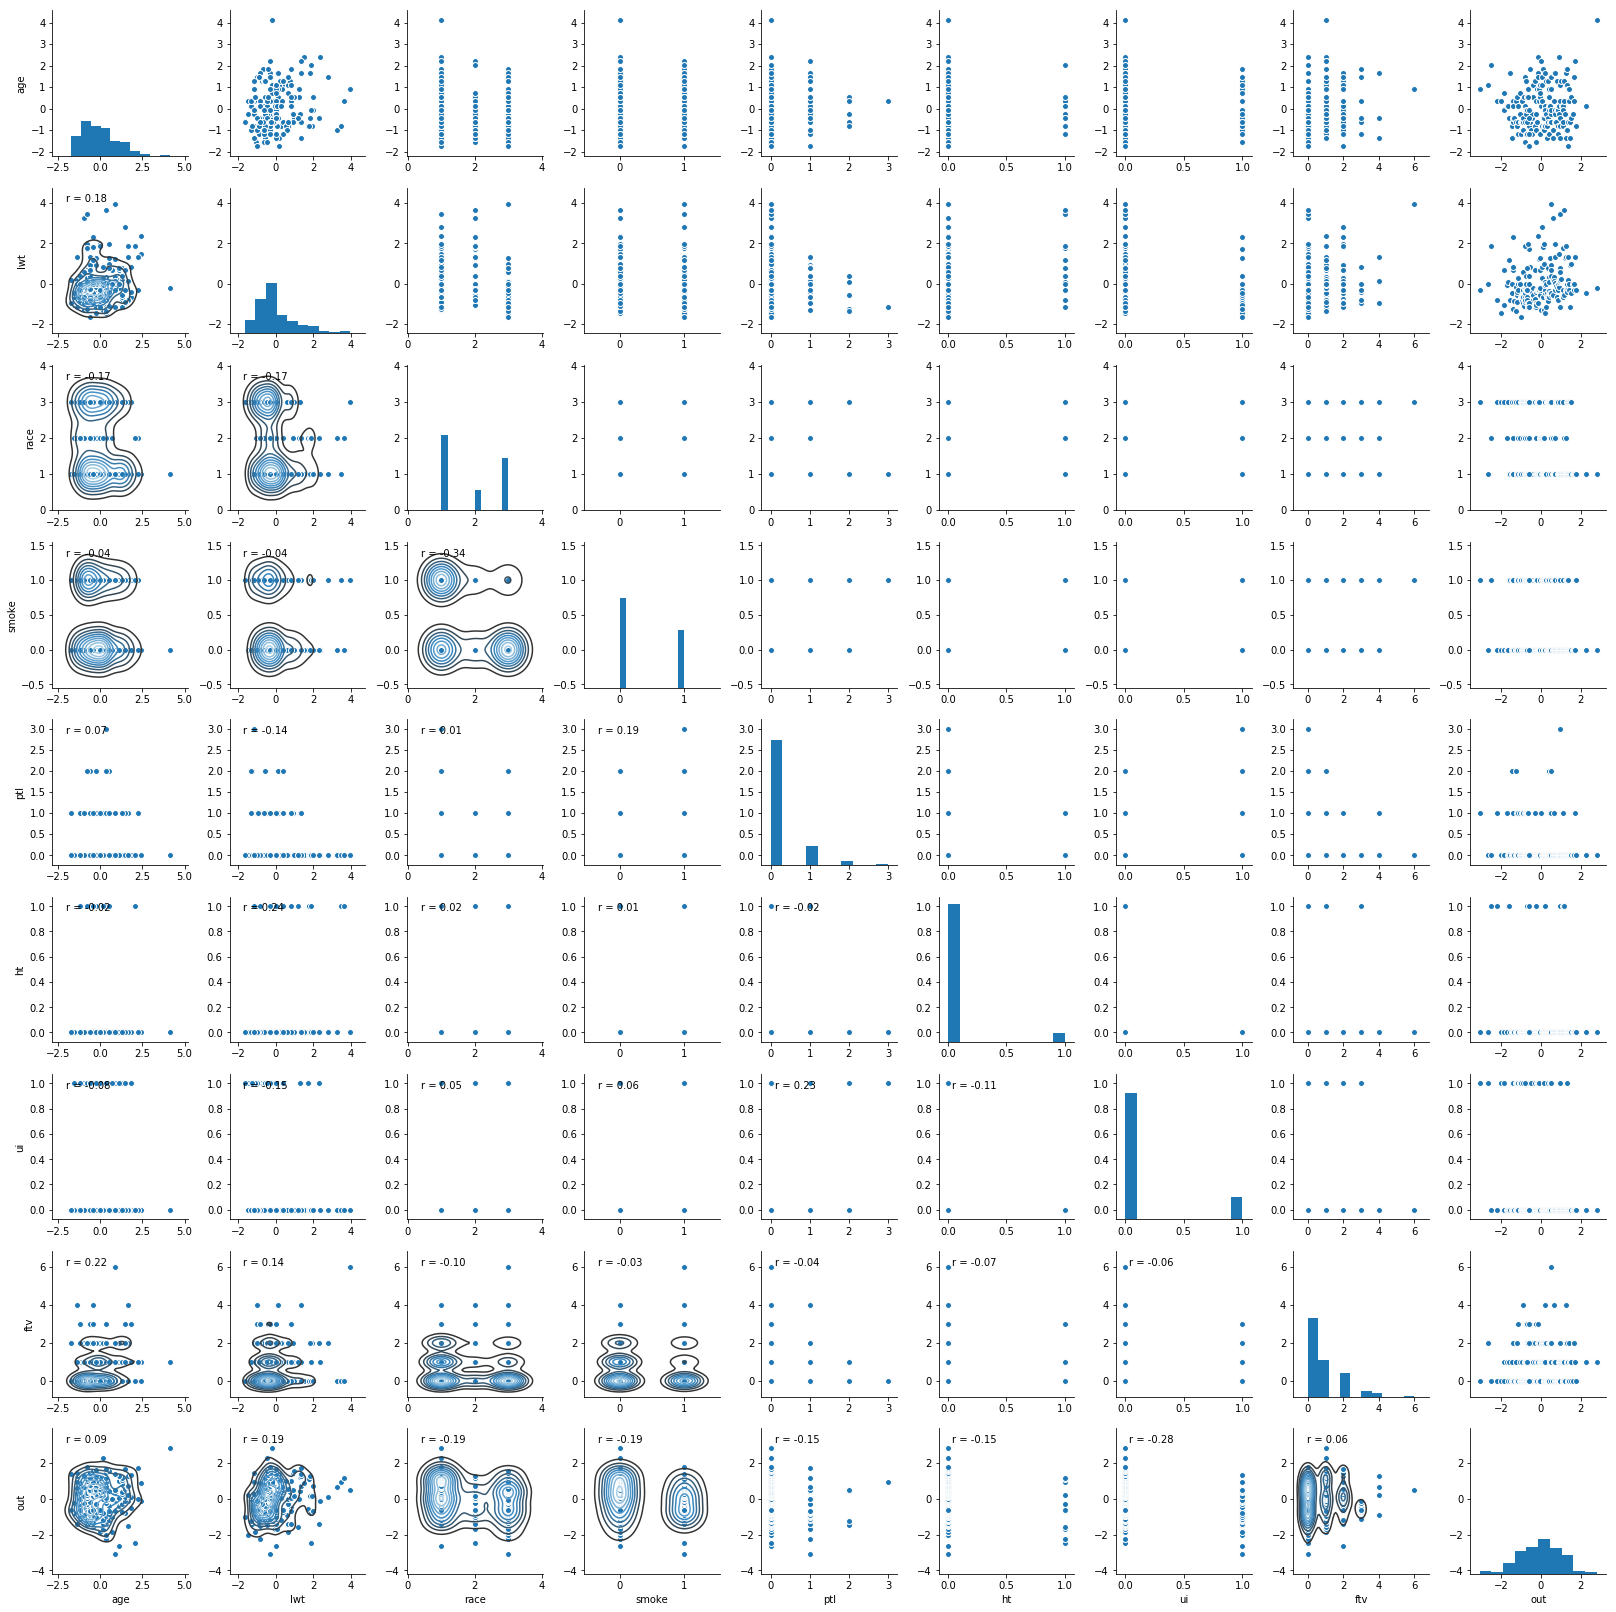

In [38]:
g = sns.pairplot(pd.DataFrame(np.hstack((X, y[:, None])), columns=feat_names + ['out']))
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

Signal-to-noise ratio: 1.8582


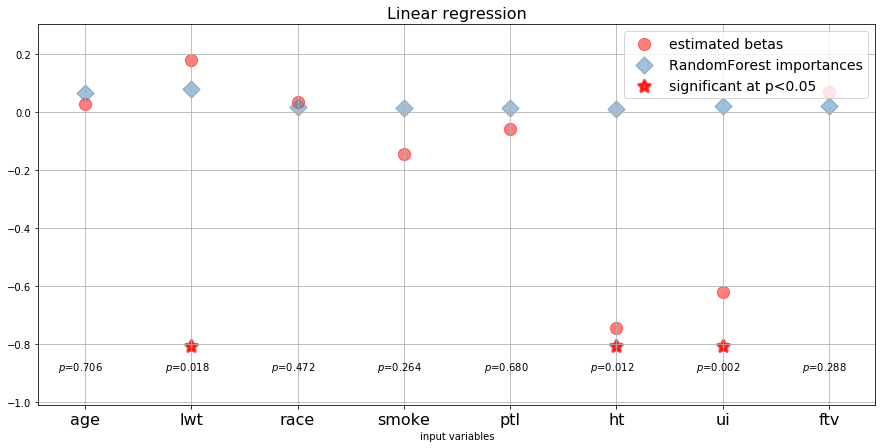

In [132]:
# ordinary least squares
model = OLS(y, X)
res = model.fit()
lr_coefs = res.params
lr_pvalues = res.pvalues

snr = (norm(a=lr_coefs, ord=2) ** 2) / (norm(a=res.resid, ord=2) ** 2)
print('Signal-to-noise ratio: %.4f' % snr)

rf_cmp.fit(X, y)
rf_cmp.feature_importances_

# compute Lasso regularization paths
C_grid = np.logspace(-2.5, 0.25, 25)
#coef_list, acc_list, nonzero_list, unbiased_acc_list = compute_Lasso_regpath(X, y, C_grid)

plot_lr(None, lr_coefs, lr_pvalues, feat_names, rf_cmp_coef=rf_cmp.feature_importances_ * np.mean(np.abs(lr_coefs)))
#plot_regr_paths(coef_list, acc_list, nonzero_list, C_grid, feat_names, unbiased_acc_list)

In [80]:
sel_w_pvals = fwd_stepwise_selection(pd.DataFrame(X, columns=feat_names), y, verbose=True)
print('Forward-stepwise selection: ' +  ' -> '.join(sel_w_pvals))

Add  ui                             with p-value 7.51844e-05
Add  race                           with p-value 0.0099902
Add  smoke                          with p-value 0.000239631
Add  ht                             with p-value 0.01275
Add  lwt                            with p-value 0.038581
Add  ptl                            with p-value 0.614145
Add  ftv                            with p-value 0.732379
Add  age                            with p-value 0.977929
Forward-stepwise selection: ui -> race -> smoke -> ht -> lwt -> ptl -> ftv -> age


### conclusion: significant, but challenging to predict (10% population variance)
### not explained by sample size that is relatively low (n=189)
### 3/8 input variables significant, but 7/8 necessary for low R=0.1 accuracy

In [40]:
print(res.summary(xname=feat_names))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     3.724
Date:                Sun, 11 Mar 2018   Prob (F-statistic):           0.000468
Time:                        18:51:29   Log-Likelihood:                -253.78
No. Observations:                 189   AIC:                             523.6
Df Residuals:                     181   BIC:                             549.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0275      0.073      0.378      0.7